In [86]:
import pandas as pd  
import sqlite3


conn = sqlite3.connect("Database/database.sqlite")


df_teams = pd.read_sql_query("SELECT * FROM team;", conn)
df_countries = pd.read_sql_query("SELECT * FROM country;", conn)
df_matchs = pd.read_sql_query("SELECT * FROM match;", conn)
df_leagues = pd.read_sql_query("SELECT * FROM league;", conn)
df_player = pd.read_sql_query("SELECT * FROM player;", conn)
df_player_attribute = pd.read_sql_query("SELECT * FROM Player_Attributes;", conn)
df_teams_attributes=pd.read_sql_query("select * from team_attributes;",conn)

df_matchs=df_matchs.drop(columns=['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA'])

conn.close()


#### Création d’une Vue Consolidée

In [87]:
player_team=df_player.merge(df_teams)
player_team_att=player_team.merge(df_player_attribute,on='id')
full_team=pd.merge(player_team,df_teams)

full_team.set_index(keys='id')['team_long_name'].reset_index()
 



,id,team_long_name
0,1,KRC Genk
1,2,Beerschot AC
2,3,SV Zulte-Waregem
3,4,Sporting Lokeren
4,5,KSV Cercle Brugge
...,...,...
78,9556,AS Saint-Étienne
79,10300,RC Lens
80,10309,Montpellier Hérault SC
81,10312,US Boulogne Cote D'Opale


#### Analyse des Joueurs : 
les joueurs les plus performants de chaque saison 

In [88]:
import xml.etree.ElementTree as ET
import pandas as pd
from collections import defaultdict
import pandas as pd

def store_goals_to_dataframe(xml_data,a):
    
    
    # Parse the XML data
    root = ET.fromstring(xml_data)
    goals_list = []

    # Iterate over each 'value' element inside 'goal'
    for value in root.findall('value'):
        goal_data = defaultdict(lambda: None) 

       
        goal_data['goal_id'] = int(value.find('id').text) if value.find('id') is not None else None
        goal_data['team'] = int(value.find('team').text) if value.find('team') is not None else None
        goal_data['player1'] = int(value.find('player1').text) if value.find('player1') is not None else None
        goal_data['player2'] = int(value.find('player2').text) if value.find('player2') is not None else None
        goal_data['elapsed'] = int(value.find('elapsed').text) if value.find('elapsed') is not None else None
        goal_data['goal_type'] = value.find('goal_type').text if value.find('goal_type') is not None else None
        goal_data['goal_subtype'] = value.find('subtype').text if value.find('subtype') is not None else None
        goal_data['goal_comment'] = value.find('comment').text if value.find('comment') is not None else None
        goal_data['event_type'] = int(value.find('event_incident_typefk').text) if value.find('event_incident_typefk') is not None else None
        goal_data['sort_order'] = int(value.find('sortorder').text) if value.find('sortorder') is not None else None
        goal_data['type_goal'] = value.find('type').text if value.find('type') is not None else None
        goal_data['stats'] = value.find('stats') 
        goal_data['match_id']=a
     
        if goal_data['stats'] is not None:
            goal_data['goals'] = int(goal_data['stats'].find('goals').text) if goal_data['stats'].find('goals') is not None else None
        else:
            goal_data['goals'] = None
            
        goals_list.append(goal_data)

    goal_df = pd.DataFrame(goals_list)

    return goal_df



df_without_Nan = df_matchs.dropna(subset=['goal'])
l = df_without_Nan['goal']
all_goals_df = []


for index, value in enumerate(l):
    goal_df = store_goals_to_dataframe(value,df_without_Nan.index[index])
    all_goals_df.append(goal_df)

final_goals_df = pd.concat(all_goals_df, ignore_index=True)



/tmp/ipykernel_4666/135406638.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_goals_df = pd.concat(all_goals_df, ignore_index=True)


In [6]:
df_without_Nan.index[2]



np.int64(1730)

In [7]:
link_match_goal_goalkeepers = pd.merge(final_goals_df, df_matchs, left_on='match_id', right_on='id')
link_match_goal_players = pd.merge(link_match_goal_goalkeepers, df_player, left_on='player1', right_on='player_api_id')


link_match_goal_assists = pd.merge(link_match_goal_goalkeepers, df_player, left_on='player2', right_on='player_api_id')

goal_scorers = link_match_goal_players.groupby(['player_name', 'season'])['goals'].sum().sort_values(ascending=False).reset_index()
assisters = link_match_goal_assists.groupby(['player_name', 'season'])['goals'].sum().sort_values(ascending=False).reset_index()

assisters.rename(columns={
    'goals':'assists'
},inplace=True)
goal_scorers_assists=pd.merge(goal_scorers,assisters,on=['player_name','season'])

goal_scorers_assists

,player_name,season,goals,assists
0,Lionel Messi,2014/2015,43.0,18.0
1,Lionel Messi,2011/2012,40.0,15.0
2,Cristiano Ronaldo,2014/2015,40.0,16.0
3,Luis Suarez,2015/2016,40.0,16.0
4,Zlatan Ibrahimovic,2015/2016,38.0,13.0
...,...,...,...,...
5297,Sven van Beek,2014/2015,0.0,1.0
5298,Stewart Downing,2008/2009,0.0,3.0
5299,Stewart Downing,2011/2012,0.0,2.0
5300,Billy Jones,2011/2012,0.0,1.0


visualization

/tmp/ipykernel_4276/3809434809.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_assisters.values, y=best_assisters.index, ax=axes[1], palette='viridis')
/tmp/ipykernel_4276/3809434809.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')


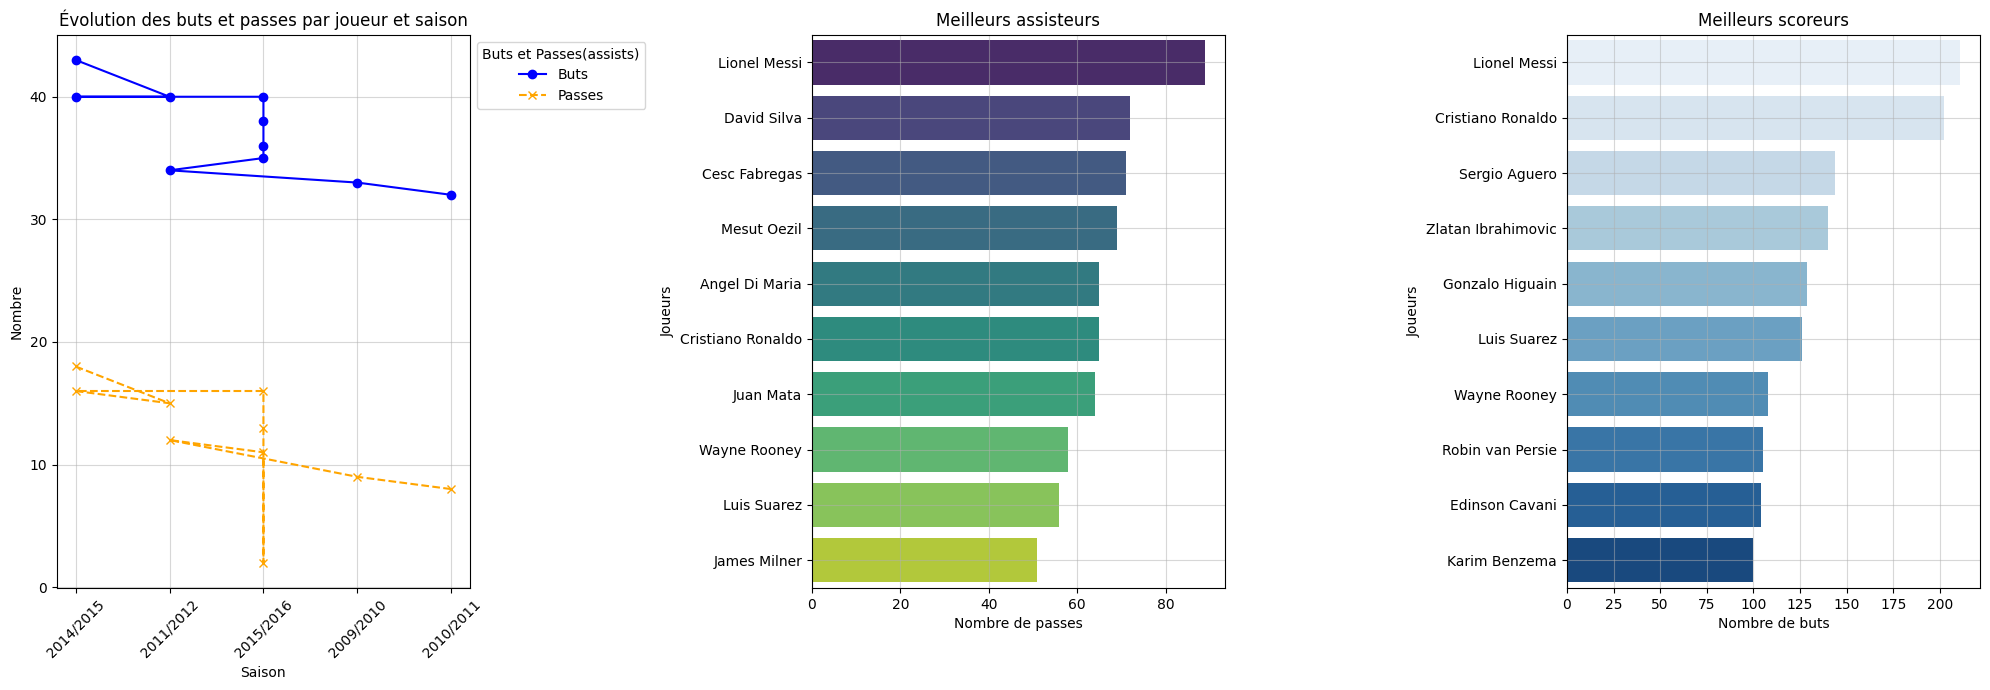

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# premier plot : evolution des buts et assists en function des season
axes[0].plot(goal_scorers_assists['season'].head(10), goal_scorers_assists['goals'].head(10), label='Buts', linestyle='-', marker='o', color='blue')
axes[0].plot(goal_scorers_assists['season'].head(10), goal_scorers_assists['assists'].head(10), label='Passes', linestyle='--', marker='x', color='orange')

axes[0].set_title("Évolution des buts et passes par joueur et saison")
axes[0].set_xlabel("Saison")
axes[0].set_ylabel("Nombre")
axes[0].grid(True, alpha=0.5)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Buts et Passes(assists)")

# Rotate
axes[0].tick_params(axis='x', rotation=45)

# represent des assists par joueurs
best_assisters = goal_scorers_assists.groupby('player_name')['assists'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=best_assisters.values, y=best_assisters.index, ax=axes[1], palette='viridis')

axes[1].set_title("Meilleurs assisteurs")
axes[1].set_xlabel("Nombre de passes")
axes[1].grid(True, alpha=0.5)
axes[1].set_ylabel("Joueurs")

# represent des buts par joueurs
best_goals = goal_scorers_assists.groupby('player_name')['goals'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')

axes[2].set_title("Meilleurs scoreurs")
axes[2].set_xlabel("Nombre de buts")
axes[2].grid(True, alpha=0.5)
axes[2].set_ylabel("Joueurs")

plt.tight_layout()

plt.show()


==> métrique de performance en combinant la note globale, le potentiel, et d'autres attributs.

In [9]:
player_att=df_player.merge(df_player_attribute,on='player_api_id')
result=player_att.groupby('player_name').agg({
      'potential':'mean',
   'overall_rating':'mean',
   'dribbling':'mean'
   })
result_=result.sort_values(by=['potential','overall_rating','dribbling'],ascending=False).reset_index()
result_['performance_score'] = result_['potential'] + result_['overall_rating'] + result_['dribbling']
top_performers = result_.head(10)
top_performers


,player_name,potential,overall_rating,dribbling,performance_score
0,Lionel Messi,95.230769,92.192308,96.461538,283.884615
1,Cristiano Ronaldo,93.480000,91.280000,92.640000,277.400000
2,Fabio Cannavaro,90.833333,85.166667,52.000000,228.000000
3,Neymar,90.760000,83.800000,91.600000,266.160000
4,Andres Iniesta,90.560000,88.320000,90.080000,268.960000
5,Mario Goetze,90.147059,83.176471,88.617647,261.941176
6,Zlatan Ibrahimovic,90.047619,88.285714,89.380952,267.714286
7,Roy Makaay,90.000000,78.333333,71.333333,239.666667
8,James Rodriguez,89.954545,83.000000,85.000000,257.954545
9,Franck Ribery,89.916667,88.458333,92.916667,271.291667


/tmp/ipykernel_4276/162360998.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='performance_score', y='player_name', data=top_performers, palette='viridis')


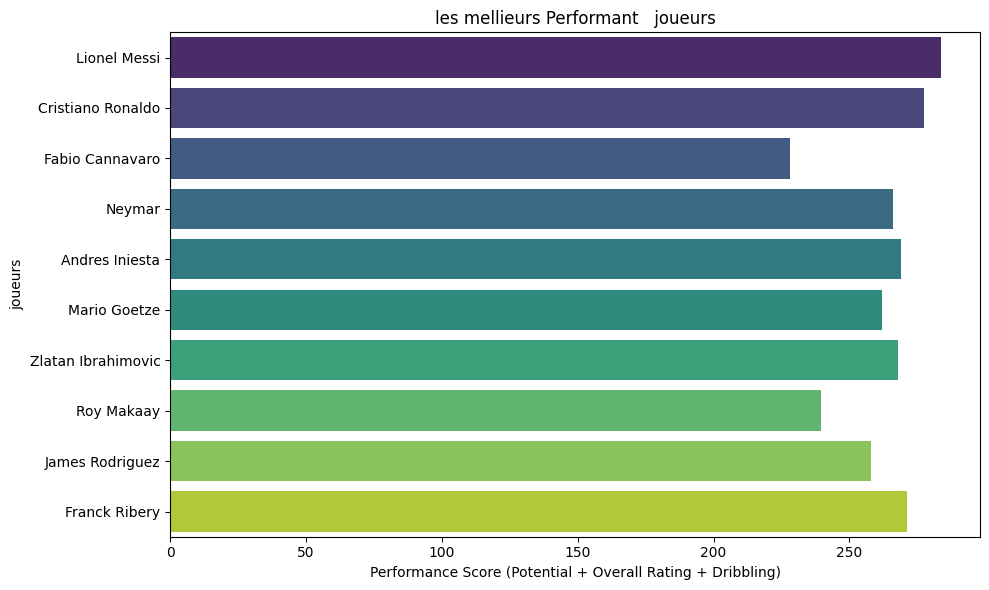

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x='performance_score', y='player_name', data=top_performers, palette='viridis')

# Add titles and labels
plt.title("les mellieurs Performant   joueurs")
plt.xlabel("Performance Score (Potential + Overall Rating + Dribbling)")
plt.ylabel("joueurs")

# Show the plot
plt.tight_layout()
plt.show()

In [11]:

sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')

axes[2].set_title("Meilleurs scoreurs")
axes[2].set_xlabel("Nombre de buts")
axes[2].grid(True, alpha=0.5)
axes[2].set_ylabel("Joueurs")

plt.tight_layout()


/tmp/ipykernel_4276/3776427909.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')


<Figure size 640x480 with 0 Axes>

equipe +++++++++++

In [12]:

df_leagues.columns
result=pd.merge(df_matchs,df_leagues,left_on='league_id',right_on='id')

result=result.merge(final_goals_df,left_on='id_x',right_on='match_id')
result_=result.groupby(['name','team'])['goals'].sum().reset_index().sort_values(by='goals',ascending=False)
result_m=pd.merge(result_,df_teams, left_on='team',right_on='team_api_id',how='inner')
# result_m.rename(columns={
#     'name':'league_name'
# })
# result_m
best_teams = result_m.loc[result_.groupby('name')['goals'].idxmax()]
best_teams


,name,team,goals,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
1,Spain LIGA BBVA,8633.0,778.0,43040,8633,243.0,Real Madrid CF,REA
6,England Premier League,10260.0,523.0,3457,10260,11.0,Manchester United,MUN
60,France Ligue 1,9827.0,228.0,9539,9827,59.0,Girondins de Bordeaux,BOR
93,France Ligue 1,7794.0,150.0,12594,7794,58.0,SC Bastia,BAS
125,Netherlands Eredivisie,8674.0,74.0,26548,8674,1915.0,FC Groningen,GRO
142,Switzerland Super League,9931.0,48.0,49118,9931,896.0,FC Basel,BAS
158,Spain LIGA BBVA,10278.0,33.0,44557,10278,100879.0,Hércules Club de Fútbol,HER
159,Germany 1. Bundesliga,8234.0,33.0,19916,8234,111239.0,FC Ingolstadt 04,ING
179,Switzerland Super League,10190.0,25.0,49479,10190,898.0,FC St. Gallen,GAL
202,Poland Ekstraklasa,2183.0,1.0,31448,2183,1570.0,P. Warszawa,PWA


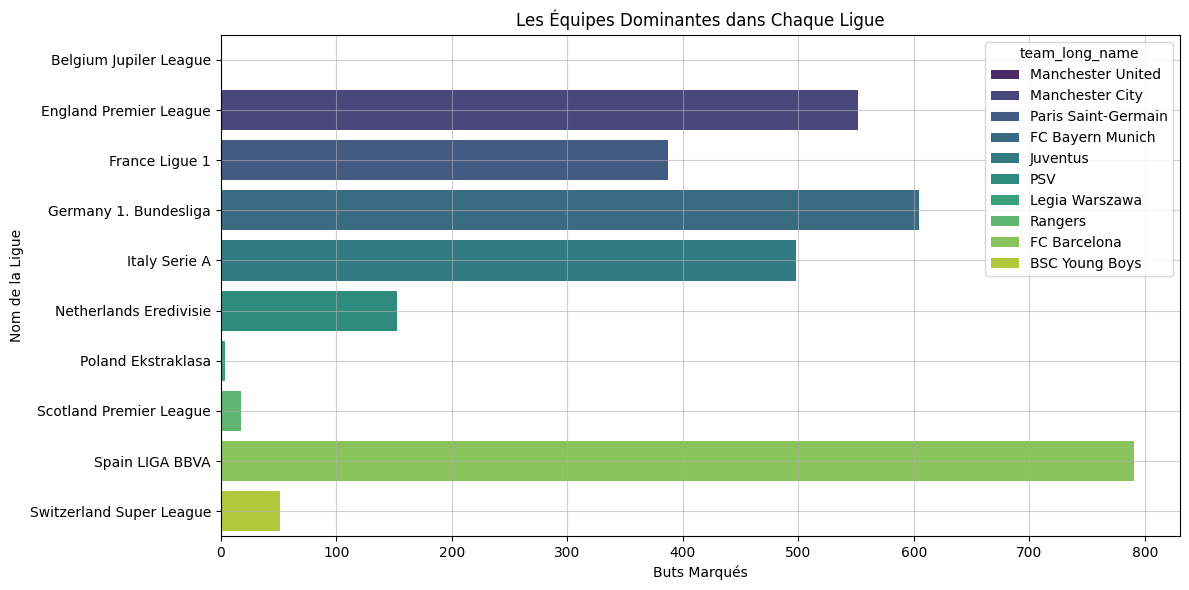

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Regrouper les données par ligue et par équipe pour calculer la somme des buts
result_ = result_m.groupby(['name', 'team_long_name'])['goals'].sum().reset_index()

# Sélectionner l'équipe avec le plus grand nombre de buts dans chaque ligue
best_teams = result_.loc[result_.groupby('name')['goals'].idxmax()]

# Affichage des résultats sous forme de graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='goals', y='name', data=best_teams, hue='team_long_name', palette='viridis')
plt.grid(True,alpha=0.6)
# Ajouter un titre et des labels
plt.title("Les Équipes Dominantes dans Chaque Ligue")
plt.xlabel("Buts Marqués")
plt.ylabel("Nom de la Ligue")

# Afficher le graphique
plt.tight_layout()
plt.show()


In [14]:
def assign_match_results(x):
    # Default values (None) to columns
    x['won_home_team'] = 'won' if x['home_team_goal'] > x['away_team_goal'] else None
    x['won_away_team'] = 'won' if x['home_team_goal'] < x['away_team_goal'] else None
    x['loss_home_team'] = 'loss' if x['home_team_goal'] < x['away_team_goal'] else None
    x['loss_away_team'] = 'loss' if x['home_team_goal'] > x['away_team_goal'] else None
    x['null'] = 1  # null column as None for all cases
    return x

# Apply the function row-wise (axis=1)
df_matchs_add = df_matchs.apply(assign_match_results, axis=1)


In [15]:
away_wins=df_matchs_add.groupby("away_team_api_id").agg({'won_away_team':'count','null':'sum','loss_away_team':'count'}).sort_values(by=['won_away_team','loss_away_team','null'],ascending=False).reset_index()
final_=pd.merge(away_wins,df_teams,left_on='away_team_api_id',right_on='team_api_id')
print("==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes reteur")
final_

==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes reteur


,away_team_api_id,won_away_team,null,loss_away_team,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,8634,103,152,18,43042,8634,241.0,FC Barcelona,BAR
1,8633,99,152,28,43040,8633,243.0,Real Madrid CF,REA
2,9925,98,152,27,39395,9925,78.0,Celtic,CEL
3,9885,84,150,30,20522,9885,45.0,Juventus,JUV
4,9823,84,136,22,15617,9823,21.0,FC Bayern Munich,BMU
...,...,...,...,...,...,...,...,...,...
294,4049,1,17,12,15,4049,NaN,Tubize,TUB
295,6631,1,17,12,30222,6631,100626.0,FC Dordrecht,DOR
296,9776,1,17,12,18691,9776,110500.0,Eintracht Braunschweig,BRA
297,6601,1,17,11,26561,6601,NaN,FC Volendam,VOL


In [16]:
home_wins=df_matchs_add.groupby(["home_team_api_id","season"]).agg({'won_home_team':'count','loss_home_team':'count','null':'sum'}).sort_values(by=['won_home_team'],ascending=False).reset_index()
final_=pd.merge(home_wins,df_teams,left_on='home_team_api_id',right_on='team_api_id')
print("==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes allez.")
print("""
      ==> Some teams perform better at home, while others may have stronger away performances.

      """)
final_

==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes allez.

      ==> Some teams perform better at home, while others may have stronger away performances.

      


,home_team_api_id,season,won_home_team,loss_home_team,null,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,9885,2013/2014,19,0,19,20522,9885,45.0,Juventus,JUV
1,8456,2011/2012,18,0,19,3466,8456,10.0,Manchester City,MCI
2,8634,2012/2013,18,0,19,43042,8634,241.0,FC Barcelona,BAR
3,8634,2009/2010,18,0,19,43042,8634,241.0,FC Barcelona,BAR
4,10260,2010/2011,18,0,19,3457,10260,11.0,Manchester United,MUN
...,...,...,...,...,...,...,...,...,...,...
1476,7869,2014/2015,1,12,19,47612,7869,1867.0,Córdoba CF,COR
1477,8177,2009/2010,1,10,17,15626,8177,166.0,Hertha BSC Berlin,HBE
1478,10215,2014/2015,1,4,17,35292,10215,1901.0,Académica de Coimbra,ACA
1479,8429,2010/2011,1,10,19,39397,8429,184.0,Hamilton Academical FC,HAM


In [17]:
df_teams_attributes.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [18]:
print(df_teams.columns)
print(df_teams_attributes.columns)

full_team_info=pd.merge(df_teams,df_teams_attributes,left_on='team_api_id',right_on='team_api_id')
grouped_data=full_team_info.groupby('team_api_id').agg({
    'buildUpPlaySpeed':'mean',
    'buildUpPlayDribbling':'mean',
    'buildUpPlayPassing':'mean',
    'chanceCreationCrossing':'mean',
    'defenceAggression':'mean',
    'defencePressure':'mean',
    'chanceCreationShooting':'mean'

}).sort_values(by=['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing','chanceCreationCrossing','defenceAggression','chanceCreationShooting','defencePressure'],ascending=False)
grouped_data.reset_index()




Index(['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name',
       'team_short_name'],
      dtype='object')
Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')


,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationCrossing,defenceAggression,defencePressure,chanceCreationShooting
0,9789,72.500000,35.0,46.50,44.500000,69.166667,59.333333,66.333333
1,8600,71.000000,62.5,53.00,64.833333,49.333333,40.666667,54.333333
2,8596,70.000000,NaN,70.00,70.000000,70.000000,60.000000,70.000000
3,158085,67.000000,66.0,39.00,59.000000,38.000000,36.000000,46.000000
4,8178,66.833333,29.5,48.00,55.833333,49.500000,57.666667,53.000000
...,...,...,...,...,...,...,...,...
283,8526,33.500000,NaN,40.50,42.500000,44.000000,47.000000,64.000000
284,2183,32.750000,NaN,44.25,49.750000,40.750000,49.500000,59.250000
285,8242,30.000000,NaN,45.00,40.000000,70.000000,70.000000,70.000000
286,6421,30.000000,NaN,30.00,50.000000,30.000000,30.000000,65.000000


Matchs

In [19]:
df_matchs

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,NaN,NaN,None,None,None,None,None,None,None,None
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,NaN,NaN,None,None,None,None,None,None,None,None
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,NaN,NaN,None,None,None,None,None,None,None,None
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,NaN,NaN,None,None,None,None,None,None,None,None
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,NaN,NaN,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,232110.0,289732.0,None,None,None,None,None,None,None,None
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,34082.0,95257.0,None,None,None,None,None,None,None,None
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,451335.0,275122.0,None,None,None,None,None,None,None,None
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,92252.0,194532.0,None,None,None,None,None,None,None,None


In [20]:
def create_scores(x):
   df_matchs['scores']=df_matchs['away_team_goal']+df_matchs['home_team_goal']
df_matchs.apply(create_scores,axis=1)

match_homeaway=df_matchs[['away_team_goal','home_team_goal','scores']].sort_values(by='scores',ascending=False).reset_index()
match_home_away=df_matchs[['away_team_goal','home_team_goal','scores']].sort_values(by='scores',ascending=False).reset_index().head(20)

 

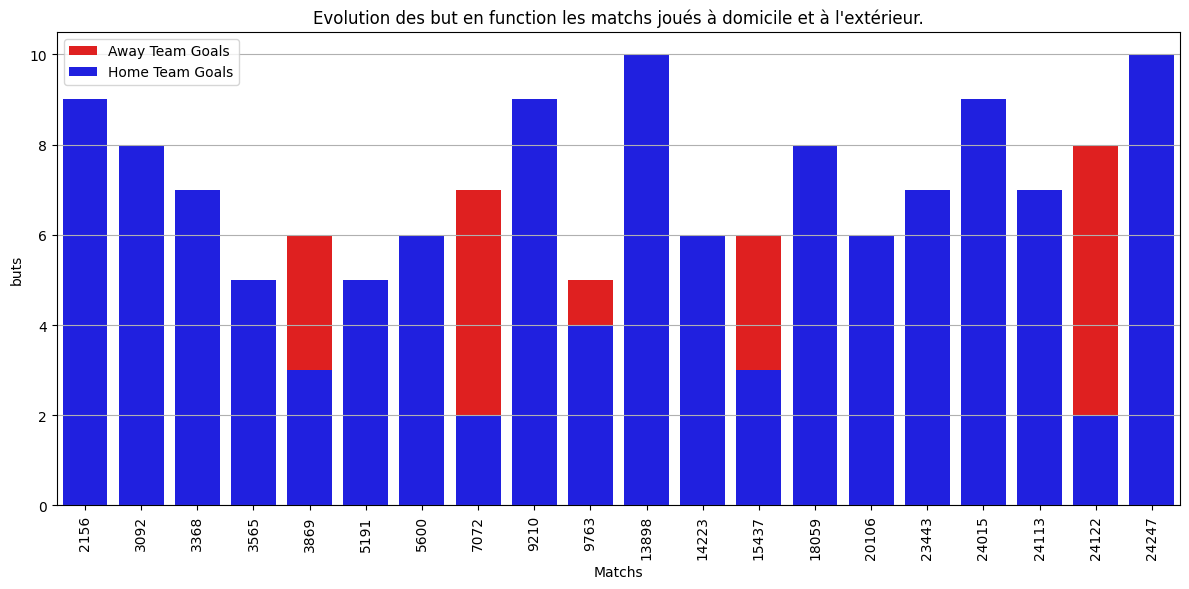

In [21]:

# Set up the visualizations
plt.figure(figsize=(12, 6))
plt.grid(True,which='both')
sns.barplot(x=match_home_away['index'], y=match_home_away['away_team_goal'], color='red', label='Away Team Goals',)
sns.barplot(x=match_home_away['index'], y=match_home_away['home_team_goal'], color='blue', label='Home Team Goals')


plt.xlabel('Matchs')
plt.ylabel('buts')
plt.title('Evolution des but en function les matchs joués à domicile et à l\'extérieur.')
plt.legend()
plt.xticks(rotation=90) 
plt.tight_layout()


plt.show()


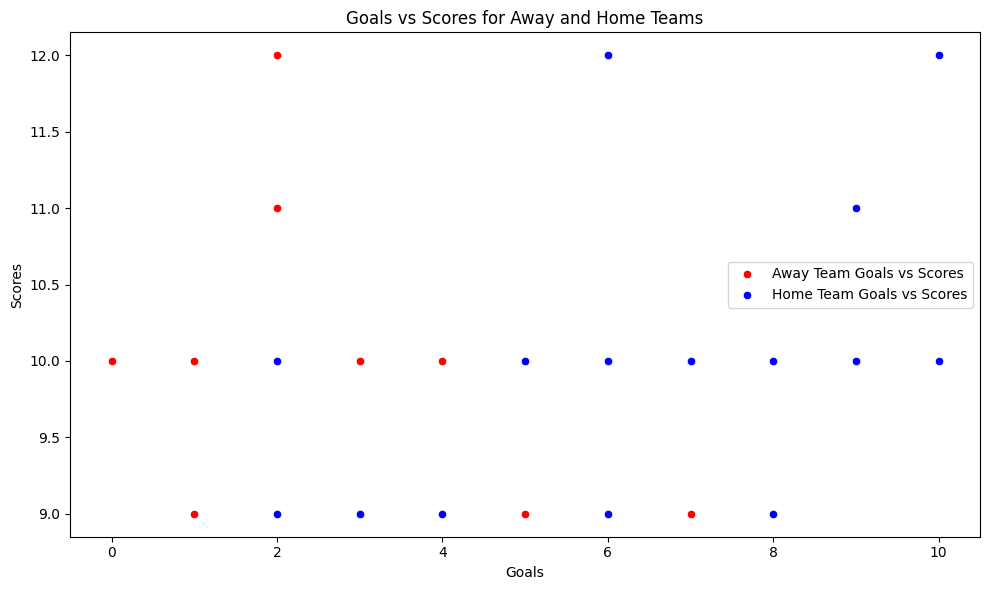

In [22]:
plt.figure(figsize=(10, 6))


sns.scatterplot(data=match_home_away, x='away_team_goal', y='scores', color='red', label='Away Team Goals vs Scores',markers=True)
sns.scatterplot(data=match_home_away, x='home_team_goal', y='scores', color='blue', label='Home Team Goals vs Scores',markers=True)

# Labels and title
plt.xlabel('Goals')
plt.ylabel('Scores')
plt.title('Goals vs Scores for Away and Home Teams')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


=> the home team scores significantly more goals than the away team. This trend is visible across the majority of matches.
=> The away team typically scores fewer goals.

=>No Strong Goal-Score Correlation

Étudiez les différences de performances entre les matchs joués à domicile et à l'extérieur

In [23]:
import xml.etree.ElementTree as ET
import pandas as pd

def extract_possession(xml_data, a):
    root = ET.fromstring(xml_data)
    
    # List to store parsed data
    possession_data = []
    
    for value in root.findall('value'):
        possession_data.append({
            'comment': value.find('comment').text if value.find('comment') is not None else None,
            'event_incident_typefk': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
            'elapsed': value.find('elapsed').text if value.find('elapsed') is not None else None,
            'elapsed_plus': value.find('elapsed_plus').text if value.find('elapsed_plus') is not None else None,
            'subtype': value.find('subtype').text if value.find('subtype') is not None else None,
            'sortorder': value.find('sortorder').text if value.find('sortorder') is not None else None,
            'awaypos': value.find('awaypos').text if value.find('awaypos') is not None else None,
            'homepos': value.find('homepos').text if value.find('homepos') is not None else None,
            'n': value.find('n').text if value.find('n') is not None else None,
            'type': value.find('type').text if value.find('type') is not None else None,
            'id': value.find('id').text if value.find('id') is not None else None,
            'id_match': a,  # Add match ID as in previous code
        })
    
    element_possession = pd.DataFrame(possession_data)
    return element_possession

possession_No_Nan = df_matchs.dropna(subset=['possession'])

possession_table = []

for index, value in enumerate(possession_No_Nan['possession']):
    possession_table.append(extract_possession(value, possession_No_Nan.index[index]))  # Use the correct index

final_possession_table = pd.concat(possession_table, ignore_index=True)

# print(final_possession_table.head())


In [24]:
import xml.etree.ElementTree as ET
import pandas as pd

foulcommit_data = []

def extract_foulcommit(xml_data,a):
    global foulcommit_data
    foulcommit_data = [] 
    
    root = ET.fromstring(xml_data)

    for value in root.findall('value'):
        foulcommit_data.append({
            'foulscommitted': value.find('stats/foulscommitted').text if value.find('stats/foulscommitted') is not None else None,
            'event_incident_typefk': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
            'elapsed': value.find('elapsed').text if value.find('elapsed') is not None else None,
            'player2': value.find('player2').text if value.find('player2') is not None else None,
            'player1': value.find('player1').text if value.find('player1') is not None else None,
            'sortorder': value.find('sortorder').text if value.find('sortorder') is not None else None,
            'team': value.find('team').text if value.find('team') is not None else None,
            'n': value.find('n').text if value.find('n') is not None else None,
            'type': value.find('type').text if value.find('type') is not None else None,
            'id': value.find('id').text if value.find('id') is not None else None,
            'subtype': value.find('subtype').text if value.find('subtype') is not None else None,  # Handle optional subtype
            'elapsed_plus': value.find('elapsed_plus').text if value.find('elapsed_plus') is not None else None,  # Handle optional elapsed_plus
            'id_match':a,
        })
    
   
    element_foulcommit = pd.DataFrame(foulcommit_data)
    return element_foulcommit

foulcommit_No_Nan = df_matchs.dropna(subset=['foulcommit'])

foulcommit_table = []
for index, value in enumerate(foulcommit_No_Nan['foulcommit']):
    foulcommit_table.append(extract_foulcommit(value,foulcommit_No_Nan.index[index]))
     
final_foulcommit_table = pd.concat(foulcommit_table, ignore_index=True)
final_foulcommit_table

,foulscommitted,event_incident_typefk,elapsed,player2,player1,sortorder,team,n,type,id,subtype,elapsed_plus,id_match
0,1,37,1,32569,25518,1,10261,267,foulcommit,378824,None,None,1728
1,1,37,2,24157,30929,0,10261,277,foulcommit,378826,None,None,1728
2,1,37,3,24148,29581,1,10261,254,foulcommit,378830,None,None,1728
3,1,37,5,40565,30373,0,10260,256,foulcommit,378841,None,None,1728
4,1,320,10,30829,29581,0,10261,275,foulcommit,378894,pushing,None,1728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219229,1,730,77,40220,213814,0,8558,465,foulcommit,4941024,trip,None,24556
219230,1,730,79,75004,452243,0,8558,462,foulcommit,4941052,trip,None,24556
219231,1,730,81,75004,629579,0,8558,477,foulcommit,4941084,trip,None,24556
219232,1,730,88,37654,210065,0,8370,484,foulcommit,4941106,trip,None,24556


In [25]:
import xml.etree.ElementTree as ET
import pandas as pd

def extract_card_data(xml_data, a):
    # Parse the XML data
    root = ET.fromstring(xml_data)
    
    card_list = []
    
    for card in root.findall(".//value"):
        card_data = {}
        
        card_data['comment'] = card.findtext('comment')
        card_data['ycards'] = card.findtext('.//ycards')
        card_data['event_incident_typefk'] = card.findtext('event_incident_typefk')
        card_data['elapsed'] = card.findtext('elapsed')
        card_data['card_type'] = card.findtext('card_type')
        card_data['subtype'] = card.findtext('subtype')
        card_data['player1'] = card.findtext('player1')
        card_data['sortorder'] = card.findtext('sortorder')
        card_data['team'] = card.findtext('team')
        card_data['n'] = card.findtext('n')
        card_data['type'] = card.findtext('type')
        card_data['id'] = card.findtext('id')
        card_data['id_match'] = a
        card_list.append(card_data)
    
    return pd.DataFrame(card_list)

card_No_Nan = df_matchs.dropna(subset=['card'])
card_table = []

for index, value in enumerate(card_No_Nan['card']):
    card_table.append(extract_card_data(value, card_No_Nan.index[index]))
     
card_table_final = pd.concat(card_table, ignore_index=True)
card_table_final

,comment,ycards,event_incident_typefk,elapsed,card_type,subtype,player1,sortorder,team,n,type,id,id_match
0,y,1,73,78,y,serious_fouls,24157,1,10260,342,card,379481,1728
1,y,1,73,82,y,serious_fouls,30362,1,10260,346,card,379503,1728
2,y,1,70,90,y,None,30829,1,10260,353,card,379547,1728
3,y,1,73,56,y,serious_fouls,37442,5,8650,327,card,377978,1730
4,y,1,25,90,y,stall_time,46621,3,8650,353,card,378060,1730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62109,y,1,70,82,y,None,25815,0,10192,23,card,5640034,25947
62110,y,1,70,52,y,None,198082,0,10243,12,card,5639986,25948
62111,y,1,70,56,y,None,121080,0,10243,13,card,5639991,25948
62112,y,1,70,60,y,None,214344,0,9824,17,card,5639996,25948


Étudiez **les différences de performances** entre les matchs joués à domicile et à l'extérieur.

In [26]:
merged_table=match_homeaway.merge(final_foulcommit_table,left_on='index',right_on='id_match')
merged_table=merged_table.merge(final_possession_table,left_on='id_match',right_on='id_match')
merged_table=merged_table.merge(card_table_final,left_on='id_match',right_on='id_match')
# result=merged_table.groupby(['id_match']).agg({
# 'ycards':'sum';
# awaypos',
# 'homepos
#  });
# result.reset_index()

# Convert necessary columns to numeric (already partially done in your code)
merged_table['foulscommitted'] = pd.to_numeric(merged_table['foulscommitted'], errors='coerce')
merged_table['ycards']=pd.to_numeric(merged_table['ycards'])
merged_table['homepos']=pd.to_numeric(merged_table['homepos'])
merged_table['awaypos']=pd.to_numeric(merged_table['awaypos'])

merged_table[['home_team_goal','away_team_goal','foulscommitted','ycards','homepos','awaypos']].dtypes
# # Group by match type and aggregate
performance_summary = merged_table.groupby(['index']).agg({
    'home_team_goal': 'mean',
    'away_team_goal': 'mean',
    'foulscommitted': 'sum',
    'ycards': 'sum',
    'homepos': 'mean',
    'awaypos': 'mean'
})

# # Rename columns for clarity
performance_summary.rename(columns={
    'home_team_goal': 'Avg_Home_Goals',
    'away_team_goal': 'Avg_Away_Goals',
    'foulscommitted': 'Fouls_Committed',
    'ycards': 'Yellow_Cards',
    'homepos': 'Avg_Home_Possession',
    'awaypos': 'Avg_Away_Possession'
}, inplace=True)

performance_summary.reset_index()


,index,Avg_Home_Goals,Avg_Away_Goals,Fouls_Committed,Yellow_Cards,Avg_Home_Possession,Avg_Away_Possession
0,1728,1.0,1.0,324.0,324.0,54.75,45.25
1,1730,0.0,1.0,200.0,200.0,45.50,54.50
2,1731,2.0,1.0,324.0,324.0,49.75,50.25
3,1732,4.0,2.0,96.0,96.0,51.50,48.50
4,1733,2.0,3.0,352.0,352.0,51.75,48.25
...,...,...,...,...,...,...,...
8120,24552,2.0,1.0,1152.0,1152.0,48.50,51.50
8121,24553,2.0,0.0,84.0,84.0,52.50,47.50
8122,24554,3.0,0.0,368.0,368.0,52.25,47.75
8123,24555,1.0,1.0,456.0,456.0,46.75,53.25


In [27]:
print(df_player_attribute.columns)
print(df_matchs.columns)

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')
Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2',
       'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6',
 

In [39]:
link_match_goal_goalkeepers = pd.merge(final_goals_df, df_matchs, left_on='match_id', right_on='id')
link_match_goal_players = pd.merge(link_match_goal_goalkeepers, df_player, left_on='player1', right_on='player_api_id')
link_match_goal_players_att= link_match_goal_players.merge(df_player_attribute,left_on='player_api_id',right_on='player_api_id')


result = link_match_goal_players_att.groupby(['season', 'player_name']).agg({
    'potential': 'mean',
    'overall_rating': 'mean',
    'dribbling': 'mean'
}).reset_index()

link_match_goal_players_att['preformance']=link_match_goal_players_att['potential']+link_match_goal_players_att['overall_rating']+link_match_goal_players_att['dribbling']

# Calculate average metrics for all players per season
seasonal_performance = link_match_goal_players_att.groupby(['season','player_name']).agg({
    'preformance':'mean'
}).reset_index()
seasonal_performance.sort_values(by='preformance')

,season,player_name,preformance
6626,2013/2014,Jesper Hansen,144.562500
4570,2011/2012,Steven Paulle,145.416667
7471,2014/2015,Andi Lila,148.200000
6291,2013/2014,Daniel Davari,148.666667
9408,2015/2016,Ezgjan Alioski,149.333333
...,...,...,...
6776,2013/2014,Lionel Messi,283.884615
571,2008/2009,Lionel Messi,283.884615
1622,2009/2010,Lionel Messi,283.884615
5440,2012/2013,Lionel Messi,283.884615


/tmp/ipykernel_4276/1629530294.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_performers = seasonal_performance.groupby('season').apply(lambda x: x.nlargest(5, 'preformance')).reset_index(drop=True)


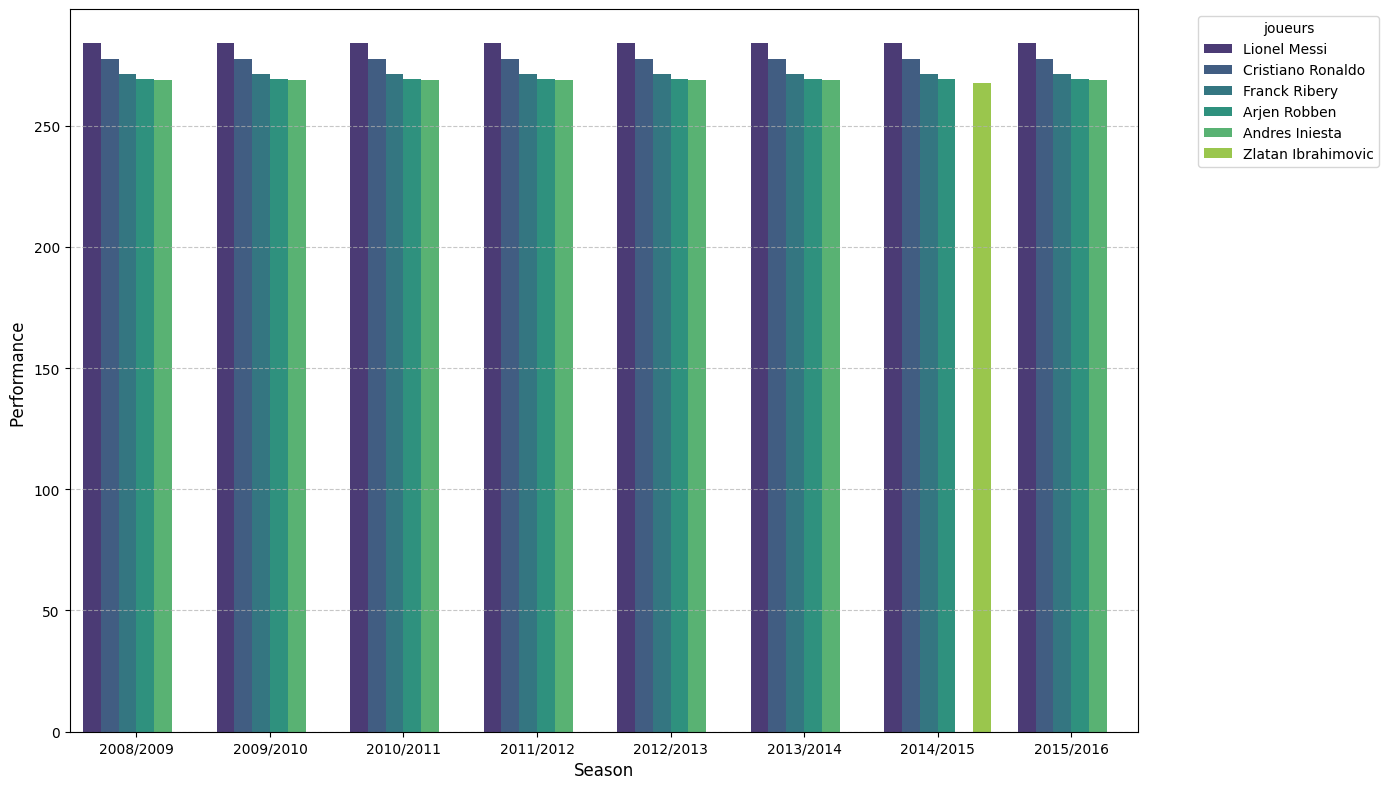

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

top_performers = seasonal_performance.groupby('season').apply(lambda x: x.nlargest(5, 'preformance')).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_performers, x='season', y='preformance', hue='player_name', dodge=True, palette='viridis')

plt.xlabel('Season', fontsize=12)
plt.ylabel('Performance ', fontsize=12)
plt.legend(title='joueurs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Clustering
=>cluster joueurs en function des attributes

In [ ]:

df=link_match_goal_players_att[link_match_goal_players_att['overall_rating'].isna()]
# link_match_goal_players_att['potential']+link_match_goal_players_att['overall_rating']+link_match_goal_players_att['dribbling']
players_with_Nan = df_player_attribute[
    df_player_attribute['potential'].isna() &
    df_player_attribute['overall_rating'].isna() &
    df_player_attribute['preferred_foot'].isna() &
    df_player_attribute['attacking_work_rate'].isna() 
]


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
483,484,33022,31684,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,984,111085,29904,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1753,165740,24159,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,2090,176941,31916,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2482,2483,177615,37249,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182587,182588,116368,25538,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183249,183250,139865,32633,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183309,183310,141272,33823,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183361,183362,168650,25772,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
import pandas as pd
procceed=pd.merge(df_player,df_player_attribute,left_on='player_api_id',right_on='player_api_id')
# print(procceed.isna().sum())
# Define the columns to fill
columns_to_fill = [
    'overall_rating', 'potential', 'preferred_foot', 'crossing', 'finishing', 'heading_accuracy',
    'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
    'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
    'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
    'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
    'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
    'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
    'gk_reflexes',
]

# Loop over each column
for col in columns_to_fill:
    if procceed[col].dtype == 'object':  # Categorical column
        mode_value = procceed[col].mode()[0]  # Get the mode (most frequent value)
        procceed[col].fillna(mode_value, inplace=True)  # Fill NaNs with the mode
    else:  # Numerical column
        mean_value = procceed[col].mean()  # Calculate the mean
        procceed[col].fillna(mean_value, inplace=True)  # Fill NaNs with the mean

# Optionally, print the columns to confirm the NaN values have been filled
print(procceed[columns_to_fill].isna().sum())


overall_rating        0
potential             0
preferred_foot        0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
dtype: int64


/tmp/ipykernel_4666/2619545634.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  procceed[col].fillna(mean_value, inplace=True)  # Fill NaNs with the mean
/tmp/ipykernel_4666/2619545634.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

In [120]:
df_player_attribute.isna().sum()

df_player_attribute.drop(columns=['attacking_work_rate','defensive_work_rate'],inplace=True)

==> exist des joueurs ont | 0:dribbling 0:overall_rating 0:potential |

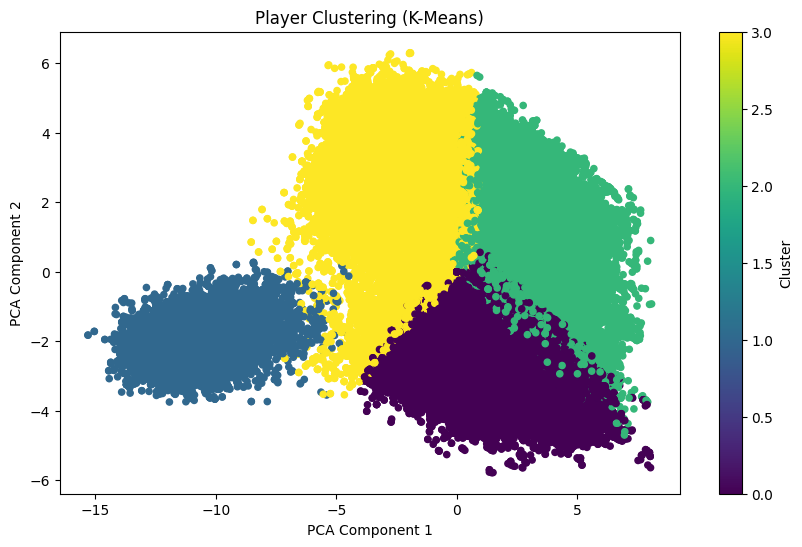

In [121]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select relevant attributes
att = procceed[['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
           'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
           'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
           'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength',
           'long_shots', 'aggression', 'interceptions', 'positioning', 'vision',
           'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
           'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

# Normalize the attributes
normalized = StandardScaler()
scaled_attributes = normalized.fit_transform(att)

inertia = []

for k in range(1, 11):  # Try k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_attributes)
    inertia.append(kmeans.inertia_)
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
procceed['cluster_kmeans'] = kmeans.fit_predict(scaled_attributes)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_attributes)

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=procceed['cluster_kmeans'], cmap='viridis', s=20)
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [122]:
cluster_counts = procceed['cluster_kmeans'].value_counts()
print("Cluster Distribution:")
print(cluster_counts)
# Get the centroids from the KMeans model
centroids = kmeans.cluster_centers_

# Optionally, inverse transform to the original scale
original_centroids = normalized.inverse_transform(centroids)
centroid_df = pd.DataFrame(original_centroids, columns=att.columns)

print("Cluster Centroids (Original Scale):")
centroid_df


Cluster Distribution:
cluster_kmeans
0    64959
2    52137
3    51979
1    14903
Name: count, dtype: int64
Cluster Centroids (Original Scale):


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,68.789224,74.061628,59.571907,65.641970,57.621673,64.894610,61.906735,69.915609,61.462436,55.772447,...,63.034076,62.891331,28.225105,32.004046,29.455011,9.911272,11.504339,15.269207,11.383023,11.346371
1,68.142656,72.518553,18.819231,18.200564,19.245253,28.053680,17.650398,18.930752,18.017476,18.439173,...,31.636081,29.615849,18.497484,19.030799,18.329949,69.779306,66.310407,64.157955,67.124069,71.343085
2,72.925226,76.671793,67.089828,54.457541,63.426607,73.132997,56.416259,67.946379,63.361302,60.086089,...,67.766639,61.726105,63.170470,68.242712,65.497639,9.888693,11.813171,20.461664,11.861595,11.842724
3,64.158713,69.760132,47.847247,34.839883,61.539991,58.472314,36.094886,48.507152,41.952104,39.536818,...,49.032043,45.694647,61.583654,64.288799,62.111493,9.734254,11.618300,16.320772,11.730485,11.680285


Clustering des Équipes :

====>  Clustering des Équipes :

Critères de Clustering : Vitesse de construction, pression défensive, précision des passes, et style de jeu.

Ajoutez des métriques comme les buts marqués et encaissés pour enrichir l’analyse.


In [123]:
df_teams.set_index(keys='id')
full_teamatt=pd.merge(df_teams,df_teams_attributes,left_on='team_api_id',right_on='team_api_id')
full_teamatt

# full_teamatt.isna().sum()
# full_teamatt.info()
full_teamatt['buildUpPlayDribblingClass'].unique()

array(['Little', 'Normal', 'Lots'], dtype=object)

In [124]:
import numpy as np

# For 'Little' class: generate random values between 24 and 33
little = full_teamatt[full_teamatt['buildUpPlayDribblingClass'] == 'Little']
x_little = np.random.uniform(24.0, 33.0, little.shape[0])
full_teamatt.loc[little.index, 'buildUpPlayDribbling'] = x_little

# For 'Normal' class: generate random values between 34 and 66
normale = full_teamatt[full_teamatt['buildUpPlayDribblingClass'] == 'Normal']
x_normal = np.random.uniform(34.0, 66.0, normale.shape[0])
full_teamatt.loc[normale.index, 'buildUpPlayDribbling'] = x_normal

# For 'Lots' class: generate random values between 67 and 77
lots = full_teamatt[full_teamatt['buildUpPlayDribblingClass'] == 'Lots']
x_lots = np.random.uniform(67.0, 77.0, lots.shape[0])
full_teamatt.loc[lots.index, 'buildUpPlayDribbling'] = x_lots

# Check if there are any remaining missing values
full_teamatt.isna().sum()


id_x                              0
team_api_id                       0
team_fifa_api_id_x                0
team_long_name                    0
team_short_name                   0
id_y                              0
team_fifa_api_id_y                0
date                              0
buildUpPlaySpeed                  0
buildUpPlaySpeedClass             0
buildUpPlayDribbling              0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPassingClass           0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationPassingClass        0
chanceCreationCrossing            0
chanceCreationCrossingClass       0
chanceCreationShooting            0
chanceCreationShootingClass       0
chanceCreationPositioningClass    0
defencePressure                   0
defencePressureClass              0
defenceAggression                 0
defenceAggressionClass            0
defenceTeamWidth                  0
defenceTeamWidthClass       

Best k based on Silhouette Score: 5 with score: 0.13769104048958367


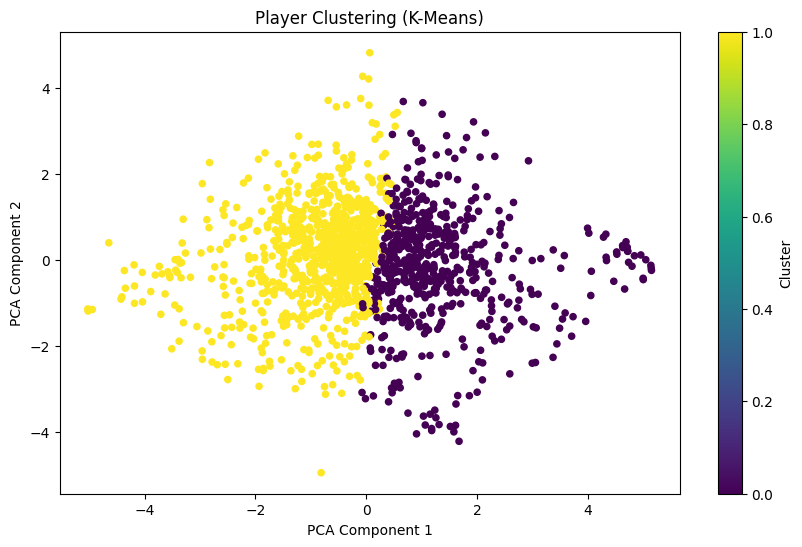

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

att = full_teamatt[[
       'buildUpPlaySpeed','buildUpPlayDribbling',
        'buildUpPlayPassing',
        
       'chanceCreationPassing', 
       'chanceCreationCrossing', 
       'chanceCreationShooting',
         'defencePressure',
       'defenceAggression', 
       'defenceTeamWidth'      
]]

normalized = StandardScaler()
scaled_attributes_team = normalized.fit_transform(att)

best_k = 0
best_score = -1

for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_attributes_team)
    score = silhouette_score(scaled_attributes_team, kmeans.labels_)
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best k based on Silhouette Score: {best_k} with score: {best_score}")

kmeans = KMeans(n_clusters=2, random_state=42)
full_teamatt['cluster_kmeans'] = kmeans.fit_predict(scaled_attributes_team)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_attributes_team)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=full_teamatt['cluster_kmeans'], cmap='viridis', s=20)
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


Best k based on BIC: 8 with BIC: 34261.35581129303


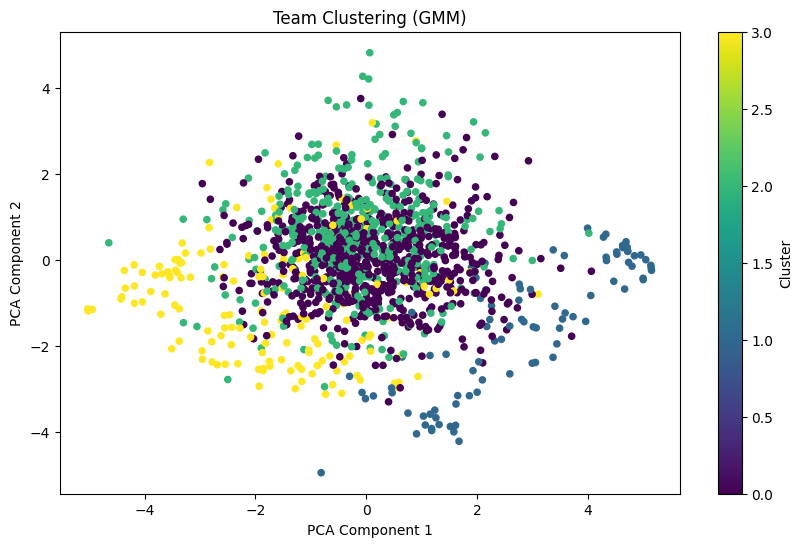

In [132]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Select relevant attributes
att = full_teamatt[[
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing',
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]]

# Normalize the data
normalized = StandardScaler()
scaled_attributes_team = normalized.fit_transform(att)

# Determine the best number of components for GMM
best_bic = np.inf
best_k = 0

for k in range(2, 11):  # Try k from 2 to 10
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_attributes_team)
    bic = gmm.bic(scaled_attributes_team)
    
    if bic < best_bic:
        best_bic = bic
        best_k = k

print(f"Best k based on BIC: {best_k} with BIC: {best_bic}")

# Apply GMM with the best k (or 3 for a reasonable guess)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(scaled_attributes_team)  # Fit the model with the data

# Now you can predict cluster labels after fitting
full_teamatt['cluster_gmm'] = gmm.predict(scaled_attributes_team)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_attributes_team)

# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=full_teamatt['cluster_gmm'], cmap='viridis', s=20)
plt.title('Team Clustering (GMM)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
